# Some Simple Models on Binary Data
- categories: [Julia, Turing, Binary]

To get myself comfortable with Julia and `Turing.jl`, I wrote out a bunch of toy models on the simplest of datasets: a  vector of binary outcomes. To keep myself honest and to have something to refer to, I'm reproducing them here.

In [2]:
#collapse
using Turing
using Bijectors
using Gadfly
using DataFrames, DataFramesMeta
Gadfly.set_default_plot_size(900px, 300px)

## Standard Biased Coin Estimation
Coinflipping is a time-honored introductory example for probability, and for good reason. Readily interpretable, amenable to both analytical solutions and manual calculation. Nevermind that ["unfair" coins are essentially impossible to make](https://www.stat.berkeley.edu/~nolan/Papers/dice.pdf)...

We'll build two models that are essentially the same but have distinct computational profiles. Bernoulli:

$$\begin{aligned}
\beta &\sim \mathrm{Beta}(1,1)\\
y_i &\sim \mathrm{Bernoulli}(\beta)\\
\end{aligned}$$

And Binomial:

$$\begin{aligned}
\beta &\sim \mathrm{Beta}(1,1)\\
\mathrm{sum}(y) &\sim \mathrm{Binomial}(\mathrm{length}(y), \beta)\\
\end{aligned}$$

### Bernoulli Model
First thing to do is to translate the Bernoulli code above into a `@model` in Turing ([docs](https://turing.ml/stable/)):

In [19]:
@model function coinflip_bernoulli(y)
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p
    for i in 1:length(y)
        y[i] ~ Bernoulli(p)
    end
end;

It looks more or less like the description above, with the loop `for i in 1:length(y)` serving the same purpose as the subscript of $y_i$. 

In [11]:
data = [1,1,1,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0]

"There are $(sum(data)) positive results out of $(length(data)) samples, for a positive rate of $(sum(data) / length(data))."

"There are 11 positive results out of 24 samples, for a positive rate of 0.4583333333333333."

So let's see what the model produces (I'll also highlight the analytical solution for the mean at 0.458).

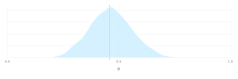

In [23]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10;

chain_bernoulli = sample(
    coinflip_bernoulli(data), 
    HMC(ϵ, τ), iterations, 
    progress=false, drop_warmup=true);

plot(DataFrame(chain_bernoulli), x=:p, xintercept=[0.458], Theme(alphas=[0.6]),
    Stat.density(bandwidth=0.02), Geom.polygon(fill=true, preserve_order=true), Geom.vline,
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0), Guide.yticks(label = false)
)

### Binomial Model
Now let's take a look at the equivalent model using a Binomial distribution that expresses the exact same underlying phenomena. In Turing:

In [24]:
@model function coinflip_binomial(heads::Int64, flips::Int64)
    # prior on p
    p ~ Beta(1, 1)
    
    # update on p
    heads ~ Binomial(flips, p)
end;

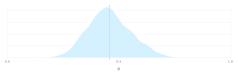

In [25]:
#collapse
heads = sum(data)
flips = length(data)

chain_binomial = sample(
    coinflip_binomial(heads, flips), 
    HMC(ϵ, τ), iterations, 
    progress=false, drop_warmup=true);

plot(DataFrame(chain_binomial), x=:p, xintercept=[0.458], Theme(alphas=[0.6]),
    Stat.density(bandwidth=0.02), Geom.polygon(fill=true, preserve_order=true), Geom.vline,
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0), Guide.yticks(label = false)
)

### Other Parameter Spaces
Going further afield, we can also model $\beta$ on an unconstrained scale ($\mathbb{R}$ instead of the unit interval $[0,1]$) by linking the domains with $\mathrm{logit}^{-1}$:

$$\begin{aligned}
\mathrm{logit}^{-1}&: \mathbb{R} \to (0, 1) \\
\mathrm{logit}^{-1}(x) &= \frac{e^x}{e^x + 1}
\end{aligned}$$

Under this transformation, we don't have to worry about ensuring our parameters stay in the range of $(0,1)$ - check out $\rho$ here:

$$\begin{aligned}
\rho &\sim \mathrm{Normal}(0, 5)\\
\beta &= \mathrm{logit}^{-1}(\rho)\\
y_i &\sim \mathrm{Bernoulli}(\beta)
\end{aligned}$$

On it's own, this seems like a frivolous transformation but it allows us to incorporate multiple signals into our determination of the probability of a positive result. Turns out, this is just logistic regression. Imagine we have one outcome $y$ that depends on several inputs $x_1, x_2, \ldots, x_n$:

$$\begin{aligned}
\rho_i &\sim \mathrm{Normal}(0,5)\\
\beta &= \mathrm{logit}^{-1}(\rho_1 x_1 + \rho_2 x_2 + \ldots + \rho_n x_n)\\
y_i &\sim \mathrm{Bernoulli}(\beta)
\end{aligned}$$

Because we pass the regression product through $\mathrm{logit}^{-1}$, we know the value of $\beta$ will be between 0 and 1. If we didn't apply this transformation then adding up the components of $\beta$ could lead to values outside of that range, (and therefore not in the support of the Bernoulli distribution) which would cause the computation to fail. 

The same approach works for the Binomial model:

$$\begin{aligned}
\rho_i &\sim \mathrm{Normal}(0,5)\\
\beta &= \mathrm{logit}^{-1}(\rho_1 x_1 + \rho_2 x_2 + \ldots + \rho_n x_n)\\
\mathrm{sum}(y) &\sim \mathrm{Binomial}(\mathrm{length}(y), \beta)
\end{aligned}$$

### Logit calculations

Turing allows us to create a `logit` function in two ways. One is in pure Julia code (note I didn't apply a type assertion to the `x` argument: things can get messy here with automatic differentiation):

In [26]:
function invlogit(x)
    ex = exp(x)
    return ex / (1 + ex)
end;

It's also possible to use the same transformations that Turing uses internally from the `Bijectors.jl` library. Some sampling algorithms like HMC require an unbounded sampling space to (at least up to `Float64` constraints...). To support that on bounded domains, the `Bijectors` library creates functions that map (smoothly) between continuous spaces ([Bijectors README](https://github.com/TuringLang/Bijectors.jl#readme)).

In [41]:
logit = bijector(Beta())   # bijection:  (0, 1)  →  ℝ
inv_logit = inv(logit)     # bijection:       ℝ  →  (0, 1)

@model function coinflip_invlogit(heads::Int64, flips::Int64)
    # prior on p
    logit_p ~ Normal(0, 5) # or any unbounded distribution
    
    # update on p
    heads ~ Binomial(flips, invlogit(logit_p))
end;

In [42]:
"Our favorite value: $(logit(0.458))."

"Our favorite value: -0.16839681732546127."

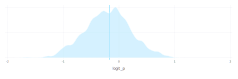

In [49]:
#collapse
heads = sum(data)
flips = length(data)

chain_invlogit = sample(
    coinflip_invlogit(heads, flips), 
    HMC(ϵ, τ), iterations, 
    progress=false, drop_warmup=true);

plot(DataFrame(chain_invlogit), x=:logit_p, xintercept=[-0.168], Theme(alphas=[0.6]),
    Stat.density(bandwidth=0.05), Geom.polygon(fill=true, preserve_order=true), Geom.vline,
    Coord.cartesian(ymin=0.0), Guide.yticks(label = false)
)

Note the new x-axis which is the transformation of the previous axis. Here are some helpful values: 

$$
\begin{aligned}\mathrm{logit}^{-1}(1.0) &= 0.73\\
\mathrm{logit}^{-1}(0) &= \frac{1}{2}\\
\mathrm{logit}^{-1}(-0.168) &= 0.458\\
\mathrm{logit}^{-1}(-1.0) &= 0.27
\end{aligned}$$

### Performance Difference
Despite describing essentially the same model, performance will differ significantly beteen the Binomial and the Bernoulli cases especially as the volume of data increases. The log-likelihood calculations in each sample loop are $O(1)$ versus $O(\mathrm{rows})$, respectively. Here's a comparison with a modestly larger dataset:

In [38]:
long_data = repeat(data, 10);
@time sample(
    coinflip(long_data), 
    HMC(ϵ, τ), iterations, 
    progress=false);

  3.516949 seconds (32.01 M allocations: 989.621 MiB, 7.51% gc time)


In [39]:
heads = sum(long_data)
flips = length(long_data)
@time sample(
    coinflip_binomial(heads, flips), 
    HMC(ϵ, τ), iterations, 
    progress=false);

  0.039479 seconds (329.91 k allocations: 23.239 MiB)


### Caution!
Just a little "gotcha" I ran into. The following model won't work, due to design choices in Turing:

In [40]:
@model function coinflip_BROKEN_THIS_WONT_WORK_AAAAAGH(y::Array{Int64})
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p                    # these lines are the problem.
    heads = sum(y)                    # heads is not RV or argument
    heads ~ Binomial(length(y), p)    # so it can't be on LHS of ~
end;

The reason is that Turing assumes that all variables on the left hand side of `~` are either 
1. random variables (generated by Turing) or
2. declared as inputs to the function

By way of analogy to Stan, the `@model` block of Turing is only intended to represent the `parameter`, `tranformed parameter` and `model` blocks of Stan. As Turing is just Julia code, this is little inconvenience (just do the data transformations in Julia first, it's more efficient anyway!) but it can be a bit of a surprise and the error message is difficult to interpret.

## Incorporating Prior Knowledge

The above models depend on unexplained constants in the Beta distribution ($\mathrm{Beta}(1,1)$ vs, say, $\mathrm{Beta}(13.859, \pi^e)$). Those choices were left unjustified and unexplained and here we'll put some more thought into them.

Let's assume you are passingly familiar with the concept of flipping coins. Consequently you reasonably expect nearly every coin to be fair and nearly every person you know to not be [Persi Diaconis](https://news.stanford.edu/pr/2004/diaconis-69.html). Personally, I'd need to see a lot of data to accept that a coin had a substantial bias, so in this section we explore how to bake that belief intentionally into our model as a prior distribution (the parameters of Beta, in this case). This is a small change to the model but we'll explore the impacts of a few alternatives:

$$\begin{aligned}
\beta &\sim \mathrm{Beta}(1,1) &\mathrm{\ versus}\\
\beta &\sim \mathrm{Beta}(5,5)  &\mathrm{\ versus}\\
\beta &\sim \mathrm{Beta}(50,50)  &\mathrm{\ versus}\\
\beta &\sim \mathrm{Beta}(15,5)&\mathrm{\ (for\ fun)}\\
\end{aligned}$$

In this particular case, the $\mathrm{Beta}$ distribution is what's known as a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for both the Bernoulli and Binomial distributions. That means we can interpret the prior as essentially just bringing more data to do table. For example, we can think of $\mathrm{Beta}(5,5)$ as showing up and pretending we'd already observed $4 = 5-1$ heads and $4=5-1$ tails ahead of time. Similarly, $\mathrm{Beta}(15,5)$ is like baking in knowledge about $14 = 15-1$ heads and $4=5-1$ tails outside of the observed data. The "subtract 1" business is just part of the $\mathrm{Beta}$ distribution details.

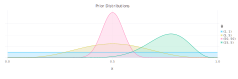

In [71]:
x = .001:0.001:.999
Θ = [(1,1), (5,5), (50,50), (15,5)]

distributions = [
    DataFrame(
        x=x, 
        ymax=pdf.(Beta(θ[1], θ[2]), x), 
        ymin=0.0, 
        θ="$θ") 
    for θ in Θ]

plot(vcat(distributions...), x=:x, y=:ymax, ymin=:ymin, ymax=:ymax, color=:θ,
    Geom.line, Geom.ribbon,
    Theme(alphas=[0.6]),
    Guide.ylabel(nothing), Guide.yticks(label=false),
    Guide.title("Prior Distributions"), 
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0)
)

In [77]:
@model function coinflip_binomial_prior(heads::Int64, flips::Int64, a, b)
    # prior on p
    p ~ Beta(a, b)
    
    # update on p
    heads ~ Binomial(flips, p)
end;

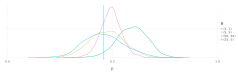

In [107]:
#collapse
function tag_column(df, tag)
    df[!,:θ] .= tag
    return df
end;

chain_binomial_by_priors = [tag_column(DataFrame(sample(
    coinflip_binomial_prior(heads, flips, θ[1], θ[2]), 
    HMC(ϵ, τ), iterations, 
    progress=false, drop_warmup=true)), "$θ") for θ in Θ];

plot(vcat(chain_binomial_by_priors...), x=:p, xintercept=[0.458], color=:θ,Theme(alphas=[0.4]),
    Geom.density,Geom.vline,
    #Stat.density(), Geom.polygon(fill=true, preserve_order=true), 
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0), Guide.yticks(label = false)
)

The posterior samples are compromises between the observed data and the prior distributions. To reinforce the previous point about conjugate priors, here are the analytically deduced posterior distributions:

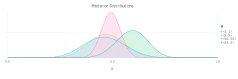

In [106]:
#collapse
θ = (26, 18)

post_distributions = [
    DataFrame(
        x=x, 
        ymax=pdf.(Beta(θ[1] + 11, θ[2] + 13), x), 
        ymin=0.0, 
        θ="$θ") 
    for θ in Θ]

plot(vcat(post_distributions...), x=:x, y=:ymax, ymin=:ymin, ymax=:ymax, color=:θ,
    Geom.line, Geom.ribbon,
    Theme(alphas=[0.6]),
    Guide.ylabel(nothing), Guide.yticks(label=false),
    Guide.title("Posterior Distributions"), 
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0)
)

You can see how it lines up with the samples from the posterior via HMC. The fun of something like Turing is that you don't always have access to simple conjugate priors for your distribution, but you can still do all the same fancy stuff even without pure analytic solutions!